# Stage 09 — Homework Starter Notebook

In the lecture, we learned how to create engineered features. Now it’s your turn to apply those ideas to your own project data.

In [1]:
import pandas as pd
import numpy as np

# Example synthetic data (replace with your project dataset)
np.random.seed(0)
n = 100
df = pd.DataFrame({
    'income': np.random.normal(60000, 15000, n).astype(int),
    'monthly_spend': np.random.normal(2000, 600, n).astype(int),
    'credit_score': np.random.normal(680, 50, n).astype(int)
})
df.head()

,income,monthly_spend,credit_score
0,86460,3129,661
1,66002,1191,668
2,74681,1237,734
3,93613,2581,712
4,88013,1296,712


In [2]:
from pathlib import Path
PROCESSED_DIR = Path('../data/processed')
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

## TODO: Implement at least 2 engineered features here

In [4]:
# --- Feature 1: spend-to-income ratio (safe division) ---
# Normalizes spend by earning power; useful if EDA showed income is skewed / drives spend.
df['spend_income_ratio'] = df['monthly_spend'] / df['income'].replace({0: np.nan})

# cap extreme ratios to avoid rare division artifacts (winsorize to 1st–99th pct)
low, high = df['spend_income_ratio'].quantile([0.01, 0.99])
df['spend_income_ratio_capped'] = df['spend_income_ratio'].clip(lower=low, upper=high)

# --- Feature 2: standardized credit score (z-score) ---
# Puts credit scores on a comparable scale; helpful for linear models / distance-based models.
mu = df['credit_score'].mean()
sd = df['credit_score'].std(ddof=0) if df['credit_score'].std(ddof=0) != 0 else 1.0
df['credit_score_z'] = (df['credit_score'] - mu) / sd

# --- Feature 3: 3-period rolling mean of spend (needs an order) ---
# If your real project has a date/user id, you should groupby user and roll over time.
# For this starter, we simulate a monthly index to demonstrate a trend-style feature.
if 'date' not in df.columns:
    df['date'] = pd.date_range('2021-01-01', periods=len(df), freq='MS')

df = df.sort_values('date').reset_index(drop=True)
df['spend_ma3'] = (
    df['monthly_spend']
    .rolling(window=3, min_periods=1)       # past 3 months, inclusive; avoids future leakage
    .mean()
)

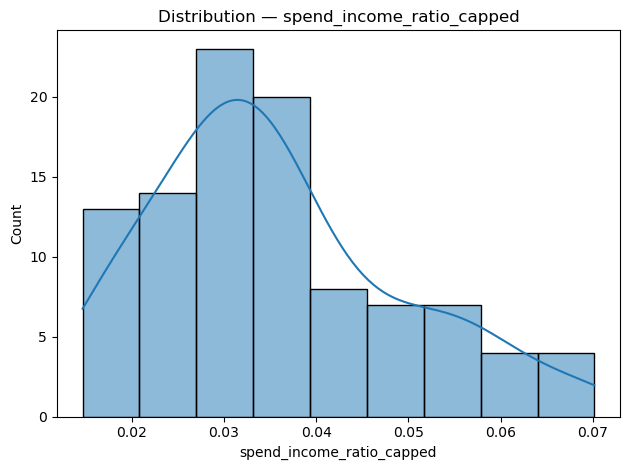

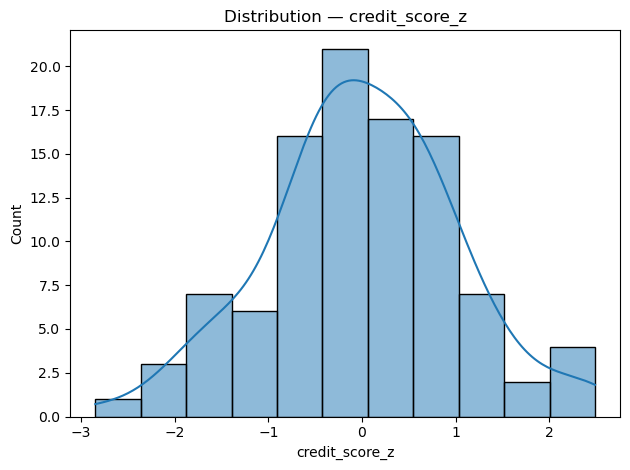

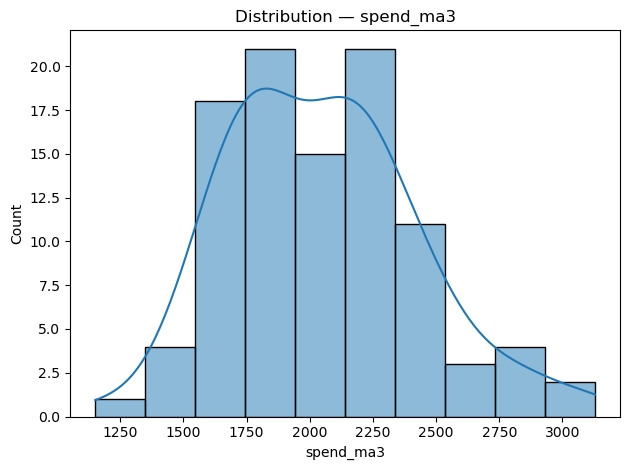

,corr_with_monthly_spend
monthly_spend,1.000000
spend_income_ratio_capped,0.702233
spend_income_ratio,0.652598
spend_ma3,0.627691
credit_score_z,0.056318


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Distribution sanity of engineered features
for col in ['spend_income_ratio_capped', 'credit_score_z', 'spend_ma3']:
    if col in df:
        plt.figure()
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution — {col}')
        plt.tight_layout()
        plt.show()

# 2) Correlation with target candidate (example: monthly_spend)
feat_cols = [c for c in ['spend_income_ratio', 'spend_income_ratio_capped', 'credit_score_z', 'spend_ma3'] if c in df]
corrs = df[feat_cols + ['monthly_spend']].corr(numeric_only=True)['monthly_spend'].sort_values(ascending=False)
corrs.to_frame('corr_with_monthly_spend')

In [6]:
out_path = PROCESSED_DIR / 'stage09_features_engineered.csv'
df.to_csv(out_path, index=False)
print(f"Saved engineered dataset to: {out_path}")


Saved engineered dataset to: ..\data\processed\stage09_features_engineered.csv


### Rationale for Feature 1
Explain why this feature may help a model. Reference your EDA.

Normalizes spend by income to capture proportional spending behavior rather than absolute dollars. 
This addresses skew we saw in income during EDA and can reduce spurious linear effects from scale.
Capped version guards against rare outliers (division artifacts) affecting model stability.

In [ ]:
# TODO: Add another feature
# Example: df['rolling_spend_mean'] = df['monthly_spend'].rolling(3).mean()

### Rationale for Feature 2
Explain why this feature may help a model. Reference your EDA.

Standardizing credit_score makes it comparable in magnitude to other features and helps models that are sensitive to scaling (e.g., regularized linear models, distance-based methods). It also centers at zero, improving interpretability of intercept terms.